# Cong Workbook


In [ ]:
# QUESTION 1: JOIN - why did movie number increase post 2nd join? duplicates?
# QUESTION 2: similar question for second join 

### Import Libraries
Let's first import some stuff

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
!pip install mysql-connector-python

In [39]:
import mysql.connector

In [40]:
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

### Loading SQL Queries

In [41]:
tn = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.tn_movie_budgets""", con))

In [42]:
#Change data types
tn['domestic_gross'] = tn['domestic_gross'].str.replace('$','')  
tn['domestic_gross'] = tn['domestic_gross'].str.replace(',','')
tn['domestic_gross'] = tn['domestic_gross'].astype(float)
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace('$','')
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace(',','')
tn['worldwide_gross'] =tn['worldwide_gross'].astype(float) 
tn['production_budget'] =tn['production_budget'].str.replace('$','')
tn['production_budget'] =tn['production_budget'].str.replace(',','')
tn['production_budget'] =tn['production_budget'].astype(float) 
tn['release_date'] = pd.to_datetime(tn['release_date'])

In [43]:
bom = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.bom_movie_gross""", con))

In [44]:
tmdb = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.tmdb_movies""", con))

In [45]:
tmd = pd.DataFrame(pd.read_sql_query("""
SELECT
	original_title,
    title,
    vote_average,
    popularity,
    release_date
FROM movies.tmdb_movies""", con))

In [46]:
tmd['release_date'] = pd.to_datetime(tmd['release_date'])
tmd = tmd.drop_duplicates(subset='original_title')

In [47]:
imdb_title_basics = pd.DataFrame(pd.read_sql_query("""
SELECT 
	original_title,
    primary_title,
    genres
FROM movies.imdb_title_basics""", con))

In [48]:
imdb_title_basics = imdb_title_basics.drop_duplicates(subset = 'original_title')

In [56]:
# SELECT *
# FROM movies.imdb_title_basics
# JOIN movies.imdb_title_ratings USING (tconst)
#to compare ImDB genre to ratings 

In [ ]:
# SELECT
# 	nconst,
#     tconst,
#     ordering,
#     category,
#     primary_title,
#     start_year,
#     genres,
#     primary_name,
#     averagerating,
#     numvotes
# FROM movies.imdb_title_principals
# JOIN movies.imdb_title_basics USING (tconst)
# JOIN movies.imdb_name_basics USING (nconst)
# JOIN movies.imdb_title_ratings USING (tconst)
# WHERE start_year >= 2015
#to show which actresses / actors / directors appeared in most highly rated movies since 2015

In [ ]:
# tn = pd.DataFrame(pd.read_sql_query("""
# SELECT Count(*)
# 	tconst,
#     primary_title,
#     averagerating,
#     numvotes
# FROM movies.imdb_title_ratings
# JOIN movies.imdb_title_basics USING (tconst)""", con))
# to join with tbi to get ratings vs. box office success correlation

### Approach 1 (NEW)

In [49]:
# JOIN bom and tn
tb = tn.join(bom.set_index('title'),
             on='movie',
             how='outer',
             lsuffix='_tn',
             rsuffix='_bom')

In [50]:
tb = tb.drop_duplicates(subset = 'movie')

In [51]:
tb.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7846 entries, 0.0 to nan
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5698 non-null   float64       
 1   release_date        5698 non-null   datetime64[ns]
 2   movie               7846 non-null   object        
 3   production_budget   5698 non-null   float64       
 4   domestic_gross_tn   5698 non-null   float64       
 5   worldwide_gross     5698 non-null   float64       
 6   studio              3386 non-null   object        
 7   domestic_gross_bom  3358 non-null   float64       
 8   foreign_gross       2037 non-null   float64       
 9   year                3386 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 674.3+ KB


In [52]:
# JOIN bom & tn and imdb_title_basics
tbi = tb.join(imdb_title_basics.set_index('original_title'),
              on='movie',
              how='left',
              rsuffix='_imdb')

In [53]:
tbi.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7846 entries, 0.0 to nan
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5698 non-null   float64       
 1   release_date        5698 non-null   datetime64[ns]
 2   movie               7846 non-null   object        
 3   production_budget   5698 non-null   float64       
 4   domestic_gross_tn   5698 non-null   float64       
 5   worldwide_gross     5698 non-null   float64       
 6   studio              3386 non-null   object        
 7   domestic_gross_bom  3358 non-null   float64       
 8   foreign_gross       2037 non-null   float64       
 9   year                3386 non-null   float64       
 10  primary_title       3284 non-null   object        
 11  genres              3284 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 796.9+ KB


In [28]:
tbi = tbi.drop_duplicates(subset = 'movie')
tbi['domestic_gross_tn'] = np.where(tbi['domestic_gross_tn'].isna(), tbi['domestic_gross_bom'], tbi['domestic_gross_tn']) 
tbi = tbi.drop(columns=['domestic_gross_bom','studio'])
tbi[['genre1','genre2','genre3']] = tbi['genres'].str.split(pat=',',expand=True)
tbi['release_month'] = tbi['release_date'].dt.month
tbi = tbi.rename(columns={'production_budget':'production_budget_$m','domestic_gross_tn':'domestic_gross_$m','worldwide_gross':'worldwide_gross_$m', 'foreign_gross':'foreign_gross_$m'})

In [29]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))

In [30]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].astype(float)
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].astype(float)
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].astype(float)
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].astype(float)

In [31]:
tbi['release_year'] = tbi['release_date'].dt.year
tbi['global_mom'] = tbi['worldwide_gross_$m'] / tbi['production_budget_$m']
tbi = tbi.round({'global_mom':2})

In [32]:
# JOIN tmd
tbi = tbi.join(tmd.set_index('original_title'),
               on='movie',
               how='left',
               rsuffix='_tmd')

In [33]:
tbi['release_date'] = np.where(tbi['release_date'].isna(), tbi['release_date_tmd'], tbi['release_date']) 

In [34]:
tbi = tbi.drop(columns=['release_date_tmd'])
tbi['release_year'] = tbi['release_date'].dt.year
tbi['release_month'] = tbi['release_date'].dt.month

In [35]:
tbi['worldwide_gross_$m'] = np.where(tbi['worldwide_gross_$m'].isna(), tbi['domestic_gross_$m'] + tbi['foreign_gross_$m'], tbi['worldwide_gross_$m'])

In [36]:
tbi.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7846 entries, 0.0 to nan
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    5698 non-null   float64       
 1   release_date          6481 non-null   datetime64[ns]
 2   movie                 7846 non-null   object        
 3   production_budget_$m  5698 non-null   float64       
 4   domestic_gross_$m     7820 non-null   float64       
 5   worldwide_gross_$m    6630 non-null   float64       
 6   foreign_gross_$m      2037 non-null   float64       
 7   year                  3386 non-null   float64       
 8   primary_title         3284 non-null   object        
 9   genres                3284 non-null   object        
 10  genre1                3284 non-null   object        
 11  genre2                2519 non-null   object        
 12  genre3                1702 non-null   object        
 13  release_month  

In [37]:
tbi.loc[tbi['movie'] == 'A Star is Born']

,id,release_date,movie,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross_$m,year,primary_title,genres,genre1,genre2,genre3,release_month,release_year,global_mom,title,vote_average,popularity
1604.0,5.0,2018-10-05,A Star is Born,36.0,215.0,433.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2018.0,12.03,NaN,NaN,NaN


### Approach 2 (OLD)

In [122]:
tmdb_bom = tmdb.join(bom.set_index('title'),
          on='original_title',
          how='outer',
          rsuffix='_bom')

In [123]:
tbt_org = tmdb_bom.join(tn.set_index('movie'),
              on='original_title',
              how='outer',
              rsuffix='_tn')

In [124]:
tbt_org = tbt_org.reset_index()

In [125]:
tbt_org['domestic_gross'] = np.where(tbt_org['domestic_gross'].isna(), tbt_org['domestic_gross_tn'], tbt_org['domestic_gross']) 

In [126]:
tbt_org['release_date'] = pd.to_datetime(tbt_org['release_date']) 

In [127]:
tbt_org['release_date'] = np.where(tbt_org['release_date'].isna(), tbt_org['release_date_tn'], tbt_org['release_date']) 

In [128]:
tbt_new = tbt_org.drop(columns=['domestic_gross_tn','title', 'release_date_tn', 'index','id','year','id_tn', 'genre_ids'])

In [130]:
tbt_new = tbt_new.drop_duplicates(subset = 'original_title')

In [132]:
tbt_new = tbt_new.dropna(subset=['domestic_gross'])

In [134]:
tbt_new = tbt_new.dropna(subset=['production_budget'])

In [137]:
tbti = tbt_new.join(imdb_title_basics.set_index('primary_title'),
                    on='original_title')

In [140]:
tbti.info() ## WHY DID title number go up even though it was a left join??

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6992 entries, 1 to 31785
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_language  2906 non-null   object        
 1   original_title     6992 non-null   object        
 2   popularity         2906 non-null   float64       
 3   release_date       6992 non-null   datetime64[ns]
 4   vote_average       2906 non-null   float64       
 5   vote_count         2906 non-null   float64       
 6   studio             1654 non-null   object        
 7   domestic_gross     6992 non-null   float64       
 8   foreign_gross      1424 non-null   float64       
 9   production_budget  6992 non-null   float64       
 10  worldwide_gross    6992 non-null   float64       
 11  genres             3606 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 710.1+ KB


### Execution

In [79]:
tbi_since1990 = tbi.loc[tbi['release_year'] > 1989]

In [80]:
genre_vs_mom = tbi_since1990.groupby(['genre1']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [81]:
genre2_vs_mom = tbi_since1990.groupby(['genre2']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [82]:
genre_vs_mom

genre1
Mystery        4.450
War            3.210
Adventure      2.450
Animation      2.400
Horror         2.400
               2.340
Sci-Fi         2.190
Action         2.000
Musical        1.900
Biography      1.870
Comedy         1.850
Documentary    1.490
Drama          1.360
Fantasy        1.340
Thriller       1.040
Crime          1.000
Romance        0.835
Sport          0.830
Music          0.500
Western        0.120
Family         0.085
Name: global_mom, dtype: float64

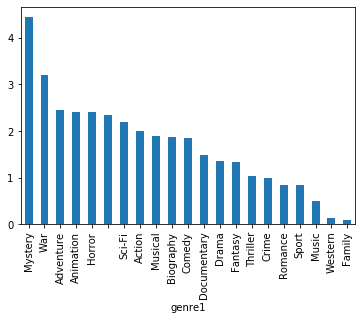

In [83]:
genre_vs_mom.plot.bar()

In [84]:
genre2_vs_mom

genre2
Mystery        2.920
Music          2.750
Animation      2.680
Adventure      2.470
Documentary    2.250
Romance        2.140
Sci-Fi         2.080
Comedy         2.050
Family         1.850
Fantasy        1.545
Drama          1.520
Crime          1.495
Horror         1.430
Thriller       1.390
Western        1.165
Sport          1.020
History        0.865
Biography      0.615
War            0.355
Musical          NaN
Name: global_mom, dtype: float64

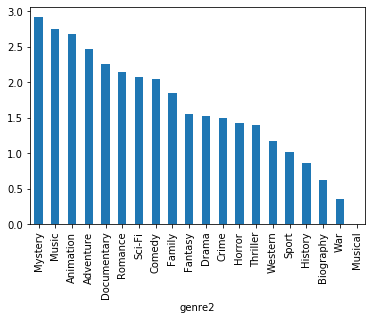

In [85]:
genre2_vs_mom.plot.bar()

OperationalError: MySQL Connection not available.

### Notes

In [ ]:
# Use below three tables to do earnings / ROI by genre by season

In [ ]:
SELECT COUNT(*) 
FROM movies.imdb_title_basics
WHERE start_year > 2010
#total 146144 rows --> starts 2010 only 

In [ ]:
SELECT COUNT(*)
FROM movies.bom_movie_gross
# total 3387 rows --> total database only has 3387 rows and starts at 2010

In [ ]:
# tn movie budgets; bom movie gross; tmbd movies with unique titles 

In [ ]:
SELECT 
	COUNT(*),
    RIGHT(release_date, 4)
FROM movies.tn_movie_budgets
GROUP BY RIGHT(release_date, 4) ASC
#5782 rows total --> 1996 first year with over 100 movies 

SELECT 
	COUNT(*)
FROM movies.tn_movie_budgets
WHERE RIGHT(release_date, 4) > 1995
#4925
#2194 for 2010 and after

In [1]:
#GENERAL Analysis (JOIN ON Movie name)
#earnings / ROI by genre (tn_movie_budgets + imdb_title_basics JOIN on movie title) POST 2010 (only 2194 movies)
#earnings / ROI by season (use only tn_movie_budgets) POST 2010 (only 2194 movies)
#ratings vs. box office success correlatoin (movie_budgets and title_basics)
#IMDB analysis (JOIN ON nmstat and tstat)
#imdb genre vs. rating (use title_basics, title_ratings JOIN on tconst) POST 2010 (limit is ratings)
#imdb actors, directors and producers with highest ratings (use title_principals, title_ratings and 
#name_basics, JOIN on tconst and nmconst) POST 2010 (limit is ratings)
#RT Analysis (JOIN ON ID)
#overview of top critics, most frequent critics and what genres they like / how harsh they are (rt_reviews)
#rt ratings vs. box office reviews vs. top critics (1500 instances approx) limited by box office numbers in movie_info

In [ ]:
# LIST of databases
## DONT USE movies.bom_movie_gross for anything 
## DONT USE movies.imdb_name basics
## DONT USE imdb title akas
## DONT USE imdb title crew
## ONLY database with too many rows is imdb principles w/ over 1m 

In [ ]:
# TO DO
## Split genre into Primary, Secondary, Tertiary (for both ImDB and RT)